In [2]:
library("lme4")
library("ggplot2")
library("dplyr")
library(MASS)
library("BayesFactor")
library("car")
library("scales")
library("lmerTest")
library("MuMIn")
library("plyr")
library("rstatix")
library("ggpubr")
library("knitr")
library("corrplot")
library("RColorBrewer")
library("svglite")

Loading required package: Matrix
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Warning message:
"package 'BayesFactor' was built under R version 3.6.3"Loading required package: coda
Warning message:
"package 'coda' was built under R version 3.6.3"************
Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************
Loading required package: carData
Registered S3 methods overwritten by 'car':
  method                          from
  influ

In [3]:
#Load the data => Here, we are filtering the cases in which subjects had a MuIFI of 0
FinalPath<-'../ToInput/R_HumMod_MS17_notemp.txt'
data <- read.delim(FinalPath, sep="\t", header=T, stringsAsFactors=F)
NoTemp_N <- nrow(data %>% filter(Temperature=="no"))
YesTemp_N <- nrow(data %>% filter(Temperature=="yes"))
data <- data %>% filter(!Amplitude==0)
data$GameSpeed <- factor(data$GameSpeed, levels = c("SSS","SMS","MSM","MMM"))
data$lCV <- log(data$CV)
filt_NoTemp_N <- nrow(data %>% filter(Temperature=="no"))
filt_YesTemp_N <- nrow(data %>% filter(Temperature=="yes"))

In [4]:
table(data$Temperature, data$GameSpeed)

       
         SSS  SMS  MSM  MMM
  Human  273  282  286  273
  no    1499 1495 1490 1499
  yes   1496 1498 1491 1499

In [5]:
##Source for "SummarySE": http://www.cookbook-r.com/Manipulating_data/Summarizing_data/
##
##
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

In [6]:
# Multiple plot function: source: http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
#
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

# Compute RMSE with new temperature ('no')

In [7]:
#RMSE function definition
RMSE = function(mod, obs){
  sqrt(mean((mod - obs)^2))
}

#Filtered data set
filt_data <- data %>% filter(!Temperature=='yes')

In [8]:
#1) Performance results
muTab<-aggregate(filt_data$Points, by=list(filt_data$Agent,filt_data$GameSpeed,filt_data$GameNb), FUN=mean)
colnames(muTab)<-c("Agent","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Agent=="Human" & muTab$GameNb==i),]$Value
}
M_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M_Mat[i,] <- muTab[which(muTab$Agent=="Model" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M_Mat) <- 1:15

H_vec <- c(H_Mat)
M_vec <- c(M_Mat)

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
condition <- c("MMM","MSM","SMS","SSS")
rs<- rep(0,4)
rmse <- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(H_Mat[,cond],M_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M_Mat[,cond],H_Mat[,cond])
}
r_tab_Perf <- data.frame(condition,r=rs)
rmse_tab_Perf <- data.frame(condition,rmse=rmse)

#correlations & RMSE in R
rs<- rep(0,15)
rmse <- rep(0,15)
for (gg in 1:15) {
    rs[gg] <- cor(H_Mat[gg,],M_Mat[gg,],method = "pearson")
    rmse[gg] <- RMSE(M_Mat[gg,],H_Mat[gg,])
}
df1 <- data.frame(GameNb=1:15,
                r=rs)
df2 <- data.frame(GameNb=1:15,
                rmse=rmse)

In [9]:
#2) Entropy results
muTab<-aggregate(filt_data$Entropy, by=list(filt_data$Agent,filt_data$GameSpeed,filt_data$GameNb), FUN=mean)
colnames(muTab)<-c("Agent","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Agent=="Human" & muTab$GameNb==i),]$Value
}
M_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M_Mat[i,] <- muTab[which(muTab$Agent=="Model" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M_Mat) <- 1:15

H_vec <- c(H_Mat)
M_vec <- c(M_Mat)

#correlations & RMSE per condition
condition <- c("MMM","MSM","SMS","SSS")
rs<- rep(0,4)
rmse <- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(H_Mat[,cond],M_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M_Mat[,cond],H_Mat[,cond])
}
r_tab_Ent <- data.frame(condition,r=rs)
rmse_tab_Ent <- data.frame(condition,rmse=rmse)

#correlations & RMSE in R
rs<- rep(0,15)
rmse <- rep(0,15)
for (gg in 1:15) {
    rs[gg] <- cor(H_Mat[gg,],M_Mat[gg,],method = "pearson")
    rmse[gg] <- RMSE(M_Mat[gg,],H_Mat[gg,])
}
df1 <- data.frame(GameNb=1:15,
                r=rs)
df2 <- data.frame(GameNb=1:15,
                rmse=rmse)

In [10]:
#3) Log CV ISI results
muTab<-aggregate(filt_data$lCV, by=list(filt_data$Agent,filt_data$GameSpeed,filt_data$GameNb), FUN=mean)
colnames(muTab)<-c("Agent","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Agent=="Human" & muTab$GameNb==i),]$Value
}
M_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M_Mat[i,] <- muTab[which(muTab$Agent=="Model" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M_Mat) <- 1:15

H_vec <- c(H_Mat)
M_vec <- c(M_Mat)

#correlations & RMSE per condition
condition <- c("MMM","MSM","SMS","SSS")
rs<- rep(0,4)
rmse <- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(H_Mat[,cond],M_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M_Mat[,cond],H_Mat[,cond])
}
r_tab_lCV <- data.frame(condition,r=rs)
rmse_tab_lCV <- data.frame(condition,rmse=rmse)

#correlations & RMSE in R
rs<- rep(0,15)
rmse <- rep(0,15)
for (gg in 1:15) {
    rs[gg] <- cor(H_Mat[gg,],M_Mat[gg,],method = "pearson")
    rmse[gg] <- RMSE(M_Mat[gg,],H_Mat[gg,])
}
df1 <- data.frame(GameNb=1:15,
                r=rs)
df2 <- data.frame(GameNb=1:15,
                rmse=rmse)

In [11]:
#4) Periodicity results
muTab<-aggregate(filt_data$Periodicity, by=list(filt_data$Agent,filt_data$GameSpeed,filt_data$GameNb), FUN=mean)
colnames(muTab)<-c("Agent","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Agent=="Human" & muTab$GameNb==i),]$Value
}
M_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M_Mat[i,] <- muTab[which(muTab$Agent=="Model" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M_Mat) <- 1:15

H_vec <- c(H_Mat)
M_vec <- c(M_Mat)

#correlations & RMSE per condition
condition <- c("MMM","MSM","SMS","SSS")
rs<- rep(0,4)
rmse <- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(H_Mat[,cond],M_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M_Mat[,cond],H_Mat[,cond])
}
r_tab_Per <- data.frame(condition,r=rs)
rmse_tab_Per <- data.frame(condition,rmse=rmse)

#correlations & RMSE in R
rs<- rep(0,15)
rmse <- rep(0,15)
for (gg in 1:15) {
    rs[gg] <- cor(H_Mat[gg,],M_Mat[gg,],method = "pearson")
    rmse[gg] <- RMSE(M_Mat[gg,],H_Mat[gg,])
}
df1 <- data.frame(GameNb=1:15,
                r=rs)
df2 <- data.frame(GameNb=1:15,
                rmse=rmse)

In [12]:
#5) Regularity results
muTab<-aggregate(filt_data$Amplitude, by=list(filt_data$Agent,filt_data$GameSpeed,filt_data$GameNb), FUN=mean)
colnames(muTab)<-c("Agent","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Agent=="Human" & muTab$GameNb==i),]$Value
}
M_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M_Mat[i,] <- muTab[which(muTab$Agent=="Model" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M_Mat) <- 1:15

H_vec <- c(H_Mat)
M_vec <- c(M_Mat)

#correlations & RMSE per condition
condition <- c("MMM","MSM","SMS","SSS")
rs<- rep(0,4)
rmse <- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(H_Mat[,cond],M_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M_Mat[,cond],H_Mat[,cond])
}
r_tab_Reg <- data.frame(condition,r=rs)
rmse_tab_Reg <- data.frame(condition,rmse=rmse)

#correlations & RMSE in R
rs<- rep(0,15)
rmse <- rep(0,15)
for (gg in 1:15) {
    rs[gg] <- cor(H_Mat[gg,],M_Mat[gg,],method = "pearson")
    rmse[gg] <- RMSE(M_Mat[gg,],H_Mat[gg,])
}
df1 <- data.frame(GameNb=1:15,
                r=rs)
df2 <- data.frame(GameNb=1:15,
                rmse=rmse)

In [13]:
#6) Resets results
muTab<-aggregate(filt_data$Resets, by=list(filt_data$Agent,filt_data$GameSpeed,filt_data$GameNb), FUN=mean)
colnames(muTab)<-c("Agent","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Agent=="Human" & muTab$GameNb==i),]$Value
}
M_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M_Mat[i,] <- muTab[which(muTab$Agent=="Model" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M_Mat) <- 1:15

H_vec <- c(H_Mat)
M_vec <- c(M_Mat)

#correlations & RMSE per condition
condition <- c("MMM","MSM","SMS","SSS")
rs<- rep(0,4)
rmse <- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(H_Mat[,cond],M_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M_Mat[,cond],H_Mat[,cond])
}
r_tab_Res <- data.frame(condition,r=rs)
rmse_tab_Res <- data.frame(condition,rmse=rmse)

#correlations & RMSE in R
rs<- rep(0,15)
rmse <- rep(0,15)
for (gg in 1:15) {
    rs[gg] <- cor(H_Mat[gg,],M_Mat[gg,],method = "pearson")
    rmse[gg] <- RMSE(M_Mat[gg,],H_Mat[gg,])
}
df1 <- data.frame(GameNb=1:15,
                r=rs)
df2 <- data.frame(GameNb=1:15,
                rmse=rmse)

In [14]:
#7) Deflations results
muTab<-aggregate(filt_data$Deflations, by=list(filt_data$Agent,filt_data$GameSpeed,filt_data$GameNb), FUN=mean)
colnames(muTab)<-c("Agent","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Agent=="Human" & muTab$GameNb==i),]$Value
}
M_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M_Mat[i,] <- muTab[which(muTab$Agent=="Model" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M_Mat) <- 1:15

H_vec <- c(H_Mat)
M_vec <- c(M_Mat)

#correlations & RMSE per condition
condition <- c("MMM","MSM","SMS","SSS")
rs<- rep(0,4)
rmse <- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(H_Mat[,cond],M_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M_Mat[,cond],H_Mat[,cond])
}
r_tab_Def <- data.frame(condition,r=rs)
rmse_tab_Def <- data.frame(condition,rmse=rmse)

#correlations & RMSE in R
rs<- rep(0,15)
rmse <- rep(0,15)
for (gg in 1:15) {
    rs[gg] <- cor(H_Mat[gg,],M_Mat[gg,],method = "pearson")
    rmse[gg] <- RMSE(M_Mat[gg,],H_Mat[gg,])
}
df1 <- data.frame(GameNb=1:15,
                r=rs)
df2 <- data.frame(GameNb=1:15,
                rmse=rmse)

In [15]:
#8) Misses results
muTab<-aggregate(filt_data$Misses, by=list(filt_data$Agent,filt_data$GameSpeed,filt_data$GameNb), FUN=mean)
colnames(muTab)<-c("Agent","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Agent=="Human" & muTab$GameNb==i),]$Value
}
M_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M_Mat[i,] <- muTab[which(muTab$Agent=="Model" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M_Mat) <- 1:15

H_vec <- c(H_Mat)
M_vec <- c(M_Mat)

#correlations & RMSE per condition
condition <- c("MMM","MSM","SMS","SSS")
rs<- rep(0,4)
rmse <- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(H_Mat[,cond],M_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M_Mat[,cond],H_Mat[,cond])
}
r_tab_Mis <- data.frame(condition,r=rs)
rmse_tab_Mis <- data.frame(condition,rmse=rmse)

#correlations & RMSE in R
rs<- rep(0,15)
rmse <- rep(0,15)
for (gg in 1:15) {
    rs[gg] <- cor(H_Mat[gg,],M_Mat[gg,],method = "pearson")
    rmse[gg] <- RMSE(M_Mat[gg,],H_Mat[gg,])
}
df1 <- data.frame(GameNb=1:15,
                r=rs)
df2 <- data.frame(GameNb=1:15,
                rmse=rmse)

In [16]:
All_rmses <- data.frame(condition,Points=rmse_tab_Perf$rmse,Entropy=rmse_tab_Ent$rmse,logCV=rmse_tab_lCV$rmse,Periodicity=rmse_tab_Per$rmse,Regularity=rmse_tab_Reg$rmse,
                     Resets=rmse_tab_Res$rmse,Deflations=rmse_tab_Def$rmse,Misses=rmse_tab_Mis$rmse)
All_rmses

condition,Points,Entropy,logCV,Periodicity,Regularity,Resets,Deflations,Misses
MMM,145.2561,0.21270353,0.4558655,80.74668,0.03863908,3.585598,1.229434,5.797483
MSM,244.6830,0.11053673,0.2099198,58.49662,0.04391037,5.728427,4.440100,8.005687
SMS,226.0335,0.06704038,0.2430459,62.98331,0.02576453,7.210624,4.382451,7.514872
SSS,507.1129,0.13160052,0.4979796,57.34365,0.04149782,2.413616,3.845649,3.894219


In [17]:
#rmse averages per measures
Points_rmse <- mean(All_rmses$Points)
Points_rmse
Ent_rmse <- mean(All_rmses$Entropy)
Ent_rmse
lCV_rmse <- mean(All_rmses$logCV)
lCV_rmse
Per_rmse <- mean(All_rmses$Periodicity)
Per_rmse
Reg_rmse <- mean(All_rmses$Regularity)
Reg_rmse
Res_rmse <- mean(All_rmses$Resets)
Res_rmse
Def_rmse <- mean(All_rmses$Deflations)
Def_rmse
Mis_rmse <- mean(All_rmses$Misses)
Mis_rmse

[1] 280.7714

[1] 0.1304703

[1] 0.3517027

[1] 64.89256

[1] 0.03745295

[1] 4.734566

[1] 3.474408

[1] 6.303065

# Alternative RMSE with new temperature ('yes')

In [18]:
#RMSE function definition
RMSE = function(mod, obs){
  sqrt(mean((mod - obs)^2))
}

#Filtered data set
filt_data2 <- data %>% filter(!Temperature=='no')

In [19]:
#1) Performance results - new temperature & Humans
muTab<-aggregate(filt_data2$Points, by=list(filt_data2$Temperature,filt_data2$GameSpeed,filt_data2$GameNb), FUN=mean)
colnames(muTab)<-c("Temperature","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Temperature=="Human" & muTab$GameNb==i),]$Value
}
M2_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M2_Mat[i,] <- muTab[which(muTab$Temperature=="yes" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M2_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M2_Mat) <- 1:15

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
condition <- c("MMM","MSM","SMS","SSS")
rmse <- rep(0,4)
rs<- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(M2_Mat[,cond],H_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M2_Mat[,cond],H_Mat[,cond])
}
rmse_perf_M2 <- rmse
rmse_perf_M2

[1] 117.8321 217.5296 227.9582 506.3334

In [20]:
#2) Entropy results - new Temperature & Humans
muTab<-aggregate(filt_data2$Entropy, by=list(filt_data2$Temperature,filt_data2$GameSpeed,filt_data2$GameNb), FUN=mean)
colnames(muTab)<-c("Temperature","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Temperature=="Human" & muTab$GameNb==i),]$Value
}
M2_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M2_Mat[i,] <- muTab[which(muTab$Temperature=="yes" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M2_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M2_Mat) <- 1:15

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
condition <- c("MMM","MSM","SMS","SSS")
rmse <- rep(0,4)
rs<- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(M2_Mat[,cond],H_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M2_Mat[,cond],H_Mat[,cond])
}
rmse_Ent_M2 <- rmse
rmse_Ent_M2

[1] 0.20811395 0.12864930 0.06945208 0.13297035

In [21]:
#3) Log CV ISI results - new Temperature & Humans
muTab<-aggregate(filt_data2$lCV, by=list(filt_data2$Temperature,filt_data2$GameSpeed,filt_data2$GameNb), FUN=mean)
colnames(muTab)<-c("Temperature","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Temperature=="Human" & muTab$GameNb==i),]$Value
}
M2_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M2_Mat[i,] <- muTab[which(muTab$Temperature=="yes" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M2_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M2_Mat) <- 1:15

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
condition <- c("MMM","MSM","SMS","SSS")
rmse <- rep(0,4)
rs<- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(M2_Mat[,cond],H_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M2_Mat[,cond],H_Mat[,cond])
}
rmse_lCV_M2 <- rmse
rmse_lCV_M2

[1] 0.4487135 0.2182773 0.2557528 0.4971121

In [22]:
#4) Periodicity results - new Temperature & Humans
muTab<-aggregate(filt_data2$Periodicity, by=list(filt_data2$Temperature,filt_data2$GameSpeed,filt_data2$GameNb), FUN=mean)
colnames(muTab)<-c("Temperature","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Temperature=="Human" & muTab$GameNb==i),]$Value
}
M2_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M2_Mat[i,] <- muTab[which(muTab$Temperature=="yes" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M2_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M2_Mat) <- 1:15

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
condition <- c("MMM","MSM","SMS","SSS")
rmse <- rep(0,4)
rs<- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(M2_Mat[,cond],H_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M2_Mat[,cond],H_Mat[,cond])
}
rmse_Per_M2 <- rmse
rmse_Per_M2

[1] 80.64563 58.03874 67.78008 55.19018

In [23]:
#5) Regularity results - new Temperature & Humans
muTab<-aggregate(filt_data2$Amplitude, by=list(filt_data2$Temperature,filt_data2$GameSpeed,filt_data2$GameNb), FUN=mean)
colnames(muTab)<-c("Temperature","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Temperature=="Human" & muTab$GameNb==i),]$Value
}
M2_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M2_Mat[i,] <- muTab[which(muTab$Temperature=="yes" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M2_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M2_Mat) <- 1:15

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
condition <- c("MMM","MSM","SMS","SSS")
rmse <- rep(0,4)
rs<- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(M2_Mat[,cond],H_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M2_Mat[,cond],H_Mat[,cond])
}
rmse_Reg_M2 <- rmse
rmse_Reg_M2

[1] 0.03465337 0.02588127 0.03266586 0.04042178

In [24]:
#6) Reset results - new Temperature & Humans
muTab<-aggregate(filt_data2$Resets, by=list(filt_data2$Temperature,filt_data2$GameSpeed,filt_data2$GameNb), FUN=mean)
colnames(muTab)<-c("Temperature","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Temperature=="Human" & muTab$GameNb==i),]$Value
}
M2_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M2_Mat[i,] <- muTab[which(muTab$Temperature=="yes" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M2_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M2_Mat) <- 1:15

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
condition <- c("MMM","MSM","SMS","SSS")
rmse <- rep(0,4)
rs<- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(M2_Mat[,cond],H_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M2_Mat[,cond],H_Mat[,cond])
}
rmse_Res_M2 <- rmse
rmse_Res_M2

[1] 3.139026 6.221140 6.109646 1.882929

In [25]:
#7) Deflation results - new Temperature & Humans
muTab<-aggregate(filt_data2$Deflations, by=list(filt_data2$Temperature,filt_data2$GameSpeed,filt_data2$GameNb), FUN=mean)
colnames(muTab)<-c("Temperature","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Temperature=="Human" & muTab$GameNb==i),]$Value
}
M2_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M2_Mat[i,] <- muTab[which(muTab$Temperature=="yes" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M2_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M2_Mat) <- 1:15

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
condition <- c("MMM","MSM","SMS","SSS")
rmse <- rep(0,4)
rs<- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(M2_Mat[,cond],H_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M2_Mat[,cond],H_Mat[,cond])
}
rmse_Def_M2 <- rmse
rmse_Def_M2

[1] 1.217421 3.235468 4.106495 3.922770

In [26]:
#8) Miss results - new Temperature & Humans
muTab<-aggregate(filt_data2$Misses, by=list(filt_data2$Temperature,filt_data2$GameSpeed,filt_data2$GameNb), FUN=mean)
colnames(muTab)<-c("Temperature","GameSpeed","GameNb","Value")
H_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    H_Mat[i,] <- muTab[which(muTab$Temperature=="Human" & muTab$GameNb==i),]$Value
}
M2_Mat <- matrix(, nrow = 15, ncol = 4)
for (i in 1:15)
{
    M2_Mat[i,] <- muTab[which(muTab$Temperature=="yes" & muTab$GameNb==i),]$Value
}
colnames(H_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(H_Mat) <- 1:15
colnames(M2_Mat) <- c("MMM","MSM","SMS","SSS")
rownames(M2_Mat) <- 1:15

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
condition <- c("MMM","MSM","SMS","SSS")
rmse <- rep(0,4)
rs<- rep(0,4)
for (cond in 1:4) {
    rs[cond] <- cor(M2_Mat[,cond],H_Mat[,cond],method = "pearson")
    rmse[cond] <- RMSE(M2_Mat[,cond],H_Mat[,cond])
}
rmse_Mis_M2 <- rmse
rmse_Mis_M2

[1] 5.471934 7.879787 7.147168 3.980021

In [27]:
All_rmses_M2 <- data.frame(rev(condition),Points=rmse_perf_M2,Entropy=rmse_Ent_M2,logCV=rmse_lCV_M2,Periodicity=rmse_Per_M2,Regularity=rmse_Reg_M2,
                     Resets=rmse_Res_M2,Deflations=rmse_Def_M2,Misses=rmse_Mis_M2)
All_rmses_M2

rev.condition.,Points,Entropy,logCV,Periodicity,Regularity,Resets,Deflations,Misses
SSS,117.8321,0.20811395,0.4487135,80.64563,0.03465337,3.139026,1.217421,5.471934
SMS,217.5296,0.12864930,0.2182773,58.03874,0.02588127,6.221140,3.235468,7.879787
MSM,227.9582,0.06945208,0.2557528,67.78008,0.03266586,6.109646,4.106495,7.147168
MMM,506.3334,0.13297035,0.4971121,55.19018,0.04042178,1.882929,3.922770,3.980021


# Line Graphs to show

In [28]:
table(data$Temperature, data$GameSpeed)

       
         SSS  SMS  MSM  MMM
  Human  273  282  286  273
  no    1499 1495 1490 1499
  yes   1496 1498 1491 1499

In [29]:
data <- data %>% filter(!GameSpeed=='MMM') %>% filter(!GameSpeed=='SSS')
Shaded <- data %>% filter(!Temperature=='no') 
datac <- summarySE(Shaded, measurevar="Amplitude", groupvars=c("GameSpeed","GameNb","Agent"))
Tra1 <- data %>% filter(Temperature=='no')
datac_b <- summarySE(Tra1, measurevar="Amplitude", groupvars=c("GameSpeed","GameNb","Agent"))

# Performance measures multiplot

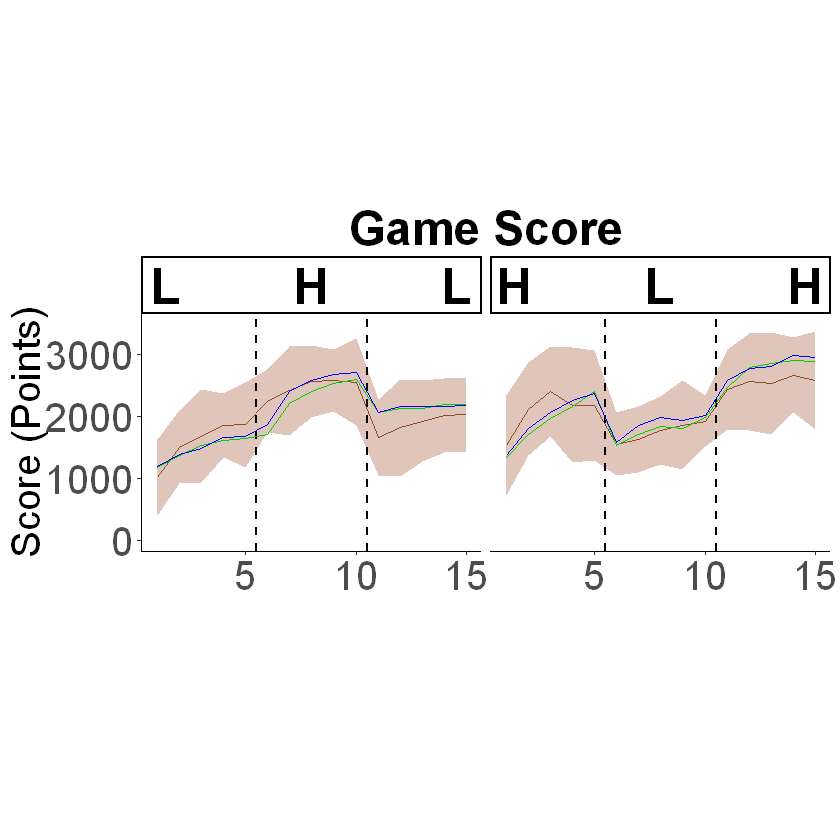

In [30]:
#Performance
Shaded <- data %>% filter(Temperature=='Human')
Agent <- Shaded$Agent
Subject <- Shaded$Subject
Points <- Shaded$Points
GameNb <- Shaded$GameNb
GameSpeed <- Shaded$GameSpeed
Rep_Nb <- 8
NewLabs <- c(MMM=paste("H","H","H", sep = strrep(" ",Rep_Nb)),MSM=paste("H","L","H", sep = strrep(" ",Rep_Nb)),SMS=paste("L","H","L", sep = strrep(" ",Rep_Nb)),SSS=paste("L","L","L", sep = strrep(" ",Rep_Nb)))
Perf_Scores <- data.frame(Agent,Subject,GameNb,GameSpeed,Points)

ar <- 0.7
args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05, 1), symbols = c("****", "***", "**", "*", ""))
sz <- 6

datac2 <- summarySE(Shaded, measurevar="Points", groupvars=c("GameSpeed","GameNb","Agent"))
Tra1 <- data %>% filter(Temperature=='no')
datac_e <- summarySE(Tra1, measurevar="Points", groupvars=c("GameSpeed","GameNb"))
Tra2 <- data %>% filter(Temperature=='yes')
datac_f <- summarySE(Tra2, measurevar="Points", groupvars=c("GameSpeed","GameNb"))
rmsePerf <- format(round(All_rmses$Points, 2), nsmall = 2)
rmsePerf2 <- format(round(All_rmses_M2$Points, 2), nsmall = 2)

p2 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=Points,colour=Agent)) + geom_ribbon(aes(x=GameNb, ymin=Points-sd, ymax=Points+sd, fill="Human")) +
      theme_classic() +
      ggtitle("Game Score") +
      theme(plot.title = element_text(size=28,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 24),
           strip.text = element_text(size = 30,face ="bold",color='black'),
           axis.title = element_text( size = 24 ),
           legend.text = element_text( size = 28),
           legend.title = element_text( size = 28),
           legend.position = 'none',
           aspect.ratio=ar
          ) +
     geom_vline(xintercept=c(5.5,10.5),linetype="dashed",lwd=0.6) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("sienna"), .33), name = "Variation (SD)") + 
     scale_color_manual(values = c("sienna4","blue","green3"), name = "Agent means") +
     scale_x_continuous(name="", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Score (Points)", limits=c(0, 3500))
p2 <- p2+ geom_line(data = datac_e, aes(x=GameNb, y=Points,color="Model (2 Temp.)")) +
      geom_line(data = datac_f, aes(x=GameNb, y=Points,color="Model (1 Temp.)")) 
h1 <- p2+facet_wrap(~ GameSpeed, labeller = labeller(GameSpeed = NewLabs), nrow = 1)
h1
pathFig <- '../Figures/Performance_temperature.png'
ggsave(pathFig,h1,width=20,height=15)

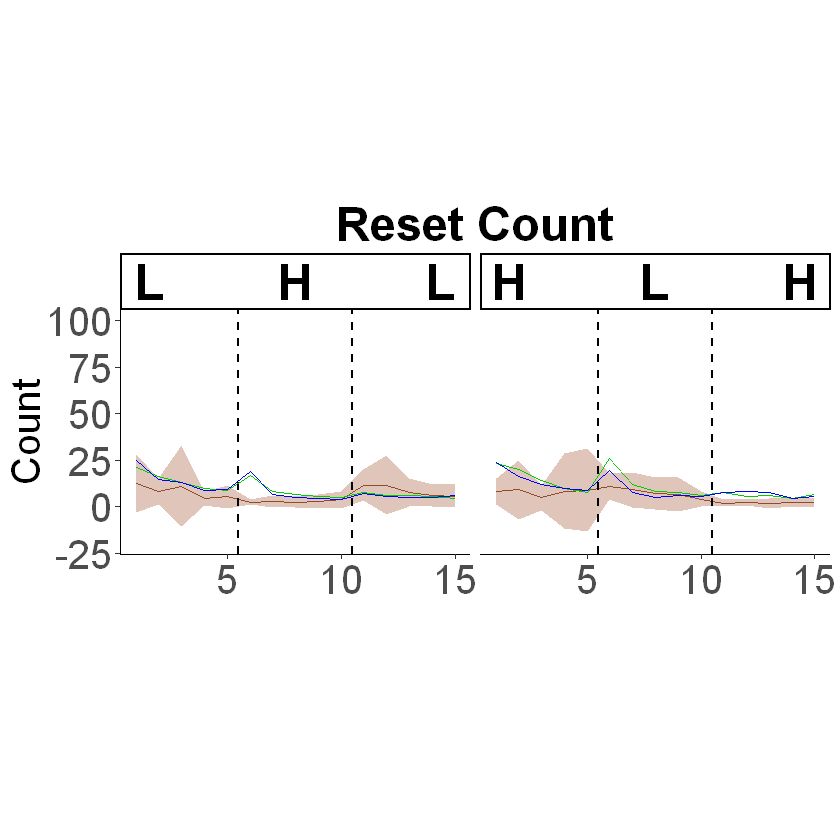

In [31]:
#Resets
Shaded <- data %>% filter(Temperature=='Human')
datac3 <- summarySE(Shaded, measurevar="Resets", groupvars=c("GameSpeed","GameNb","Agent"))
Tra1 <- data %>% filter(Temperature=='no')
datac_h1 <- summarySE(Tra1, measurevar="Resets", groupvars=c("GameSpeed","GameNb"))
Tra2 <- data %>% filter(Temperature=='yes')
datac_h2 <- summarySE(Tra2, measurevar="Resets", groupvars=c("GameSpeed","GameNb"))
rmseRe <- format(round(All_rmses$Resets, 2), nsmall = 2)
rmseRe2 <- format(round(All_rmses_M2$Resets, 2), nsmall = 2)

p3 <- ggplot(datac3) +  geom_line(aes(x=GameNb, y=Resets,colour=Agent)) + geom_ribbon(aes(x=GameNb, ymin=Resets-sd, ymax=Resets+sd, fill="Human"))+
     theme_classic() +
      ggtitle("Reset Count") +
      theme(plot.title = element_text(size=28,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 24),
           strip.text = element_text(size = 30,face ="bold",color='black'),
           axis.title = element_text( size = 24 ),
           legend.text = element_text( size = 28),
           legend.title = element_text( size = 28),
           legend.position = 'none',
           aspect.ratio=ar
          ) +
     geom_vline(xintercept=c(5.5,10.5),linetype="dashed",lwd=0.6) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("sienna"), .33), name = "Variation (SD)") + 
     scale_color_manual(values = c("sienna4","blue","green3"), name = "Agent means") +
     scale_x_continuous(name="", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Count", limits=c(-20, 100)) 
p3 <- p3+ geom_line(data = datac_h1, aes(x=GameNb, y=Resets,color="Model (2 Temp.)")) +
      geom_line(data = datac_h2, aes(x=GameNb, y=Resets,color="Model (1 Temp.)")) 
h6 <- p3+facet_wrap(~ GameSpeed, labeller = labeller(GameSpeed = NewLabs), nrow = 1)
h6
pathFig <- '../Figures/Resets_temperature.png'
ggsave(pathFig,h6,width=20,height=15)

$title
[1] "Deflations over the games"

attr(,"class")
[1] "labels"

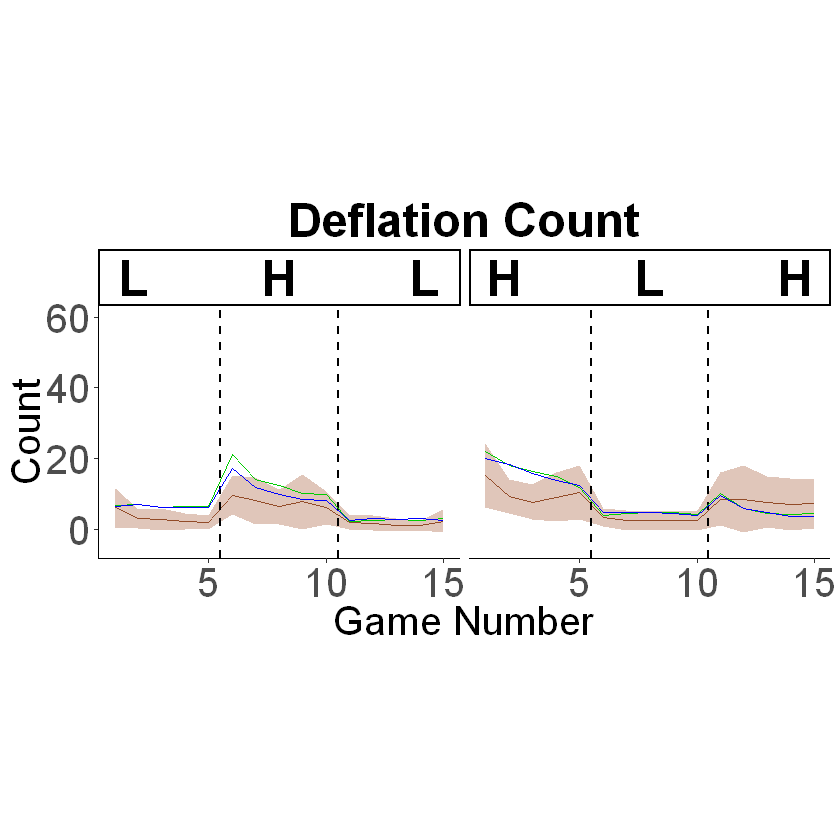

In [32]:
#Deflations

Shaded <- data %>% filter(Temperature=='Human')
datac4 <- summarySE(Shaded, measurevar="Deflations", groupvars=c("GameSpeed","GameNb","Agent"))
Tra1 <- data %>% filter(Temperature=='no')
datac_j1 <- summarySE(Tra1, measurevar="Deflations", groupvars=c("GameSpeed","GameNb"))
Tra2 <- data %>% filter(Temperature=='yes')
datac_j2 <- summarySE(Tra2, measurevar="Deflations", groupvars=c("GameSpeed","GameNb"))
rmseDe <- format(round(All_rmses$Deflations, 2), nsmall = 2)
rmseDe2 <- format(round(All_rmses_M2$Deflations, 2), nsmall = 2)

p3 <- ggplot(datac4) +  geom_line(aes(x=GameNb, y=Deflations,colour=Agent)) + geom_ribbon(aes(x=GameNb, ymin=Deflations-sd, ymax=Deflations+sd, fill="Human"))+
     theme_classic() +
      ggtitle("Deflation Count") +
      theme(plot.title = element_text(size=28,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 24),
           strip.text = element_text(size = 30,face ="bold",color='black'),
           axis.title = element_text( size = 24 ),
           legend.text = element_text( size = 28),
           legend.title = element_text( size = 28),
           legend.position = 'none',
           aspect.ratio=ar
          ) +
     geom_vline(xintercept=c(5.5,10.5),linetype="dashed",lwd=0.6) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("sienna"), .33), name = "Variation (SD)") + 
     scale_color_manual(values = c("sienna4","blue","green3"), name = "Agent means") +
     scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Count", limits=c(-5,60))
     ggtitle("Deflations over the games")
p3 <- p3+ geom_line(data = datac_j1, aes(x=GameNb, y=Deflations,color="Model (2 Temp.)")) +
      geom_line(data = datac_j2, aes(x=GameNb, y=Deflations,color="Model (1 Temp.)")) 
h7 <- p3+facet_wrap(~ GameSpeed, labeller = labeller(GameSpeed = NewLabs), nrow = 1)
h7

pathFig <- '../Figures/Deflations_temperature.png'
ggsave(pathFig,h7,width=20,height=15)

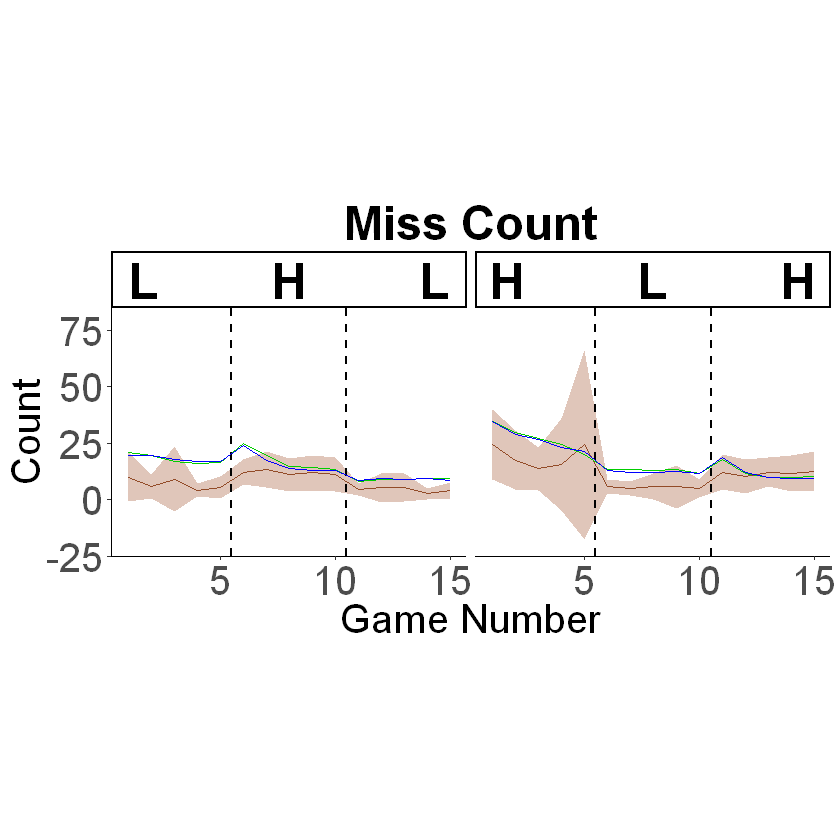

In [33]:
#Misses

Shaded <- data %>% filter(Temperature=='Human')
datac4 <- summarySE(Shaded, measurevar="Misses", groupvars=c("GameSpeed","GameNb","Agent"))
Tra1 <- data %>% filter(Temperature=='no')
datac_k1 <- summarySE(Tra1, measurevar="Misses", groupvars=c("GameSpeed","GameNb"))
Tra2 <- data %>% filter(Temperature=='yes')
datac_k2 <- summarySE(Tra2, measurevar="Misses", groupvars=c("GameSpeed","GameNb"))
rmseMi <- format(round(All_rmses$Misses, 2), nsmall = 2)
rmseMi2 <- format(round(All_rmses_M2$Misses, 2), nsmall = 2)

#Example
p1 <- ggplot(datac4) +  geom_line(aes(x=GameNb, y=Misses,colour=Agent)) + geom_ribbon(aes(x=GameNb, ymin=Misses-sd, ymax=Misses+sd, fill="Human"))+
     theme_classic() +
      ggtitle("Miss Count") +
      theme(plot.title = element_text(size=28,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 24),
           strip.text = element_text(size = 30,face ="bold",color='black'),
           axis.title = element_text( size = 24 ),
           legend.text = element_text( size = 28),
           legend.title = element_text( size = 28),
           legend.position = 'none',
           aspect.ratio=ar
          ) +
     geom_vline(xintercept=c(5.5,10.5),linetype="dashed",lwd=0.6) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("sienna"), .33), name = "Variation (SD)") + 
     scale_color_manual(values = c("sienna4","blue","green3"), name = "Agent means") +
     scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Count", limits=c(-20,80))
p1 <- p1+ geom_line(data = datac_k1, aes(x=GameNb, y=Misses,color="Model (2 Temp.)")) +
      geom_line(data = datac_k2, aes(x=GameNb, y=Misses,color="Model (1 Temp.)")) 
h8 <- p1+facet_wrap(~ GameSpeed, labeller = labeller(GameSpeed = NewLabs), nrow = 1)
h8

pathFig <- '../Figures/Misses_temperature.png'
ggsave(pathFig,h8,width=20,height=15)

In [34]:
toSave <- ggarrange(h1,h6,h7,h8, ncol=2, nrow=2, common.legend = TRUE, legend="right")
ggsave("../Figures/Fig6_I.tiff",toSave,width=24,height=9,dpi=1200)

# Measures Multiplot

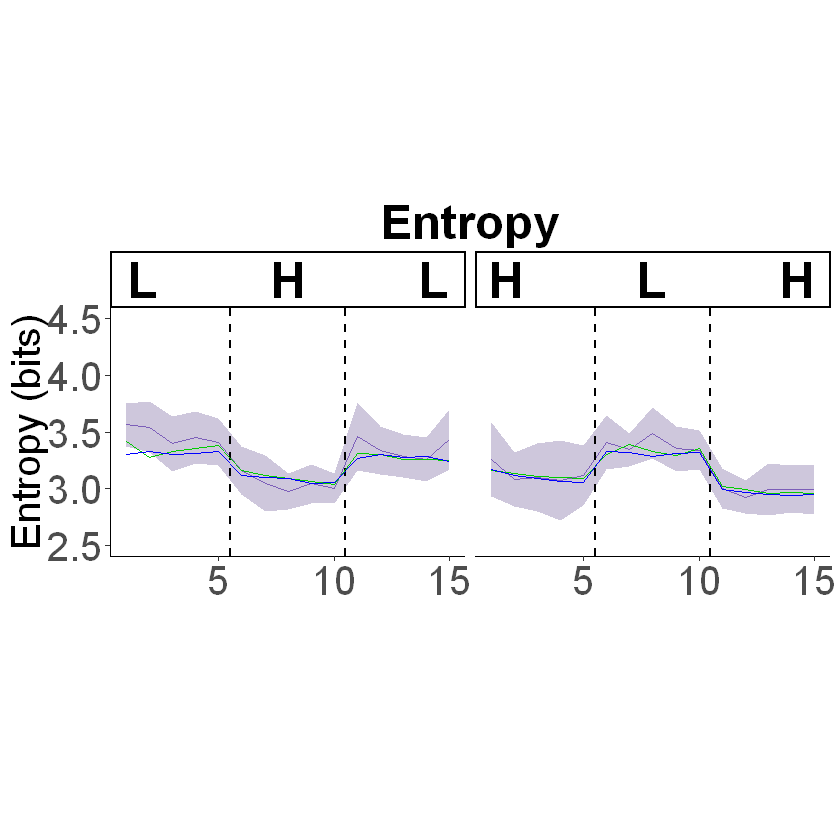

In [35]:
#Entropy
Shaded <- data %>% filter(Temperature=='Human')
datac4 <- summarySE(Shaded, measurevar="Entropy", groupvars=c("GameSpeed","GameNb","Agent"))
Tra1 <- data %>% filter(Temperature=='no')
datac_f1 <- summarySE(Tra1, measurevar="Entropy", groupvars=c("GameSpeed","GameNb"))
Tra2 <- data %>% filter(Temperature=='yes')
datac_f2 <- summarySE(Tra2, measurevar="Entropy", groupvars=c("GameSpeed","GameNb"))
rmseEn <- format(round(All_rmses$Entropy, 2), nsmall = 2)
rmseEn2 <- format(round(All_rmses_M2$Entropy, 2), nsmall = 2)

p3 <- ggplot(datac4) +  geom_line(aes(x=GameNb, y=Entropy,color=Agent)) + geom_ribbon(aes(x=GameNb, ymin=Entropy-sd, ymax=Entropy+sd, fill="Human")) +
     theme_classic() +
      ggtitle("Entropy") +
      theme(plot.title = element_text(size=28,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 24),
           strip.text = element_text(size = 30,face ="bold",color='black'),
           axis.title = element_text( size = 24 ),
           legend.text = element_text( size = 28),
           legend.title = element_text( size = 28),
           legend.position = 'none',
           aspect.ratio=ar
          ) +
     geom_vline(xintercept=c(5.5,10.5),linetype="dashed",lwd=0.6) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("mediumpurple4"), .3), name = "Variation (SD)") + 
     scale_color_manual(values = c("mediumpurple3","blue","green3"), name = "Agent means") +  
     scale_x_continuous(name="", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Entropy (bits)", limits=c(2.5, 4.5))
p3 <- p3+ geom_line(data = datac_f1, aes(x=GameNb, y=Entropy,color="Model (2 Temp.)")) +
      geom_line(data = datac_f2, aes(x=GameNb, y=Entropy,color="Model (1 Temp.)")) 
h2 <- p3+facet_wrap(~ GameSpeed, labeller = labeller(GameSpeed = NewLabs), nrow = 1)
h2
pathFig <- '../Figures/Entropy_temperature.png'
ggsave(pathFig,h2,width=20,height=15)

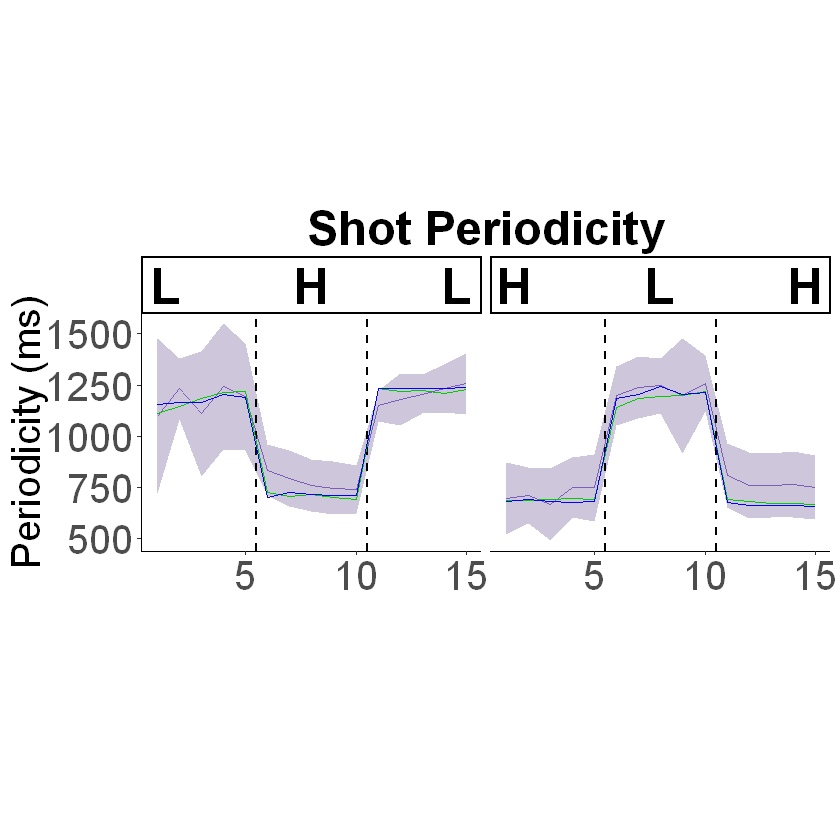

In [36]:
#Periodicity
Shaded <- data %>% filter(Temperature=='Human')
datac4 <- summarySE(Shaded, measurevar="Periodicity", groupvars=c("GameSpeed","GameNb","Agent"))
Tra1 <- data %>% filter(Temperature=='no')
datac_g1 <- summarySE(Tra1, measurevar="Periodicity", groupvars=c("GameSpeed","GameNb"))
Tra2 <- data %>% filter(Temperature=='yes')
datac_g2 <- summarySE(Tra2, measurevar="Periodicity", groupvars=c("GameSpeed","GameNb"))
rmsePe <- format(round(All_rmses$Periodicity, 2), nsmall = 2)
rmsePe2 <- format(round(All_rmses_M2$Periodicity, 2), nsmall = 2)

p4 <- ggplot(datac4) +  geom_line(aes(x=GameNb, y=Periodicity,color=Agent)) + geom_ribbon(aes(x=GameNb, ymin=Periodicity-sd, ymax=Periodicity+sd, fill="Human")) +
     theme_classic() +
      ggtitle("Shot Periodicity") +
      theme(plot.title = element_text(size=28,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 24),
           strip.text = element_text(size = 30,face ="bold",color='black'),
           axis.title = element_text( size = 24 ),
           legend.text = element_text( size = 28),
           legend.title = element_text( size = 28),
           legend.position = 'none',
           aspect.ratio=ar
          ) +
     geom_vline(xintercept=c(5.5,10.5),linetype="dashed",lwd=0.6) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("mediumpurple4"), .3), name = "Variation (SD)") + 
     scale_color_manual(values = c("mediumpurple3","blue","green3"), name = "Agent means") +     
     scale_x_continuous(name="", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Periodicity (ms)")
p4 <- p4+ geom_line(data = datac_g1, aes(x=GameNb, y=Periodicity,color="Model (2 Temp.)")) +
      geom_line(data = datac_g2, aes(x=GameNb, y=Periodicity,color="Model (1 Temp.)")) 
h3 <- p4+facet_wrap(~ GameSpeed, labeller = labeller(GameSpeed = NewLabs), nrow = 1)
h3
pathFig <- '../Figures/Periodicity_temperature.png'
ggsave(pathFig,h3,width=20,height=15)

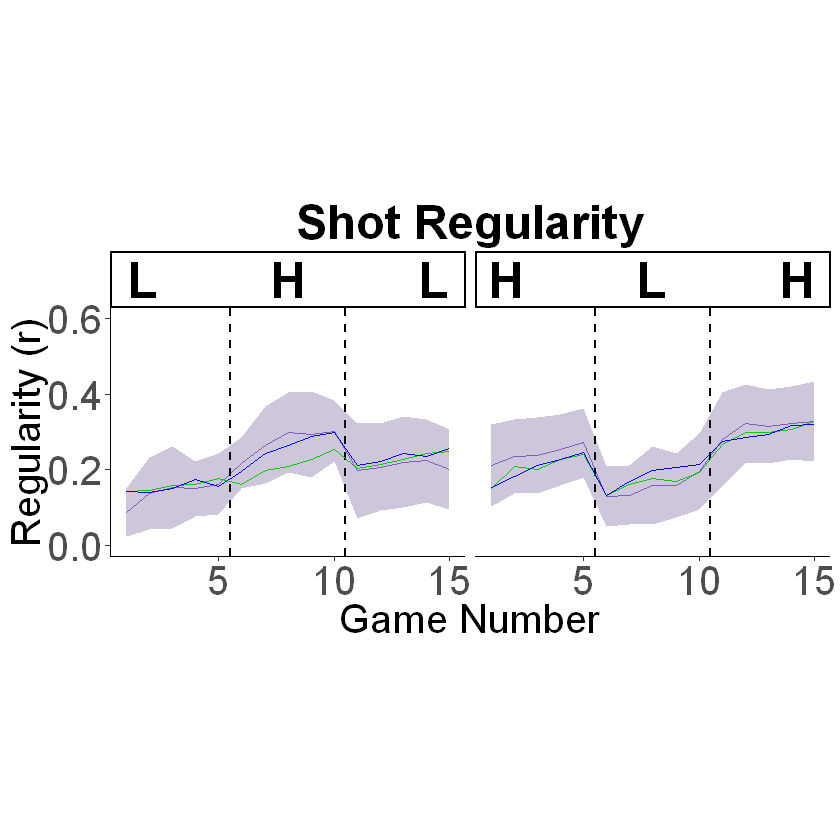

In [37]:
#Regularity
Shaded <- data %>% filter(Temperature=='Human')
datac1 <- summarySE(Shaded, measurevar="Amplitude", groupvars=c("GameSpeed","GameNb","Agent"))
Tra1 <- data %>% filter(Temperature=='no')
datac_d1 <- summarySE(Tra1, measurevar="Amplitude", groupvars=c("GameSpeed","GameNb"))
Tra2 <- data %>% filter(Temperature=='yes')
datac_d2 <- summarySE(Tra2, measurevar="Amplitude", groupvars=c("GameSpeed","GameNb"))
rmseReg <- format(round(All_rmses$Regularity, 2), nsmall = 2)
rmseReg2 <- format(round(All_rmses_M2$Regularity, 2), nsmall = 2)

p1 <- ggplot(datac1) +  geom_line(aes(x=GameNb, y=Amplitude,color=Agent)) + geom_ribbon(aes(x=GameNb, ymin=Amplitude-sd, ymax=Amplitude+sd, fill="Human")) +
     theme_classic() +
      ggtitle("Shot Regularity") +
      theme(plot.title = element_text(size=28,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 24),
           strip.text = element_text(size = 30,face ="bold",color='black'),
           axis.title = element_text( size = 24 ),
           legend.text = element_text( size = 28),
           legend.title = element_text( size = 28),
           legend.position = 'none',
           aspect.ratio=ar
          ) +
     geom_vline(xintercept=c(5.5,10.5),linetype="dashed",lwd=0.6) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("mediumpurple4"), .3), name = "Variation (SD)") + 
     scale_color_manual(values = c("mediumpurple3","blue","green3"), name = "Agent means") +
     scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Regularity (r)", limits=c(0, 0.6))
p1 <- p1+ geom_line(data = datac_d1, aes(x=GameNb, y=Amplitude,color="Model (2 Temp.)")) +
      geom_line(data = datac_d2, aes(x=GameNb, y=Amplitude,color="Model (1 Temp.)")) 
h4 <- p1+facet_wrap(~ GameSpeed, labeller = labeller(GameSpeed = NewLabs), nrow = 1)
h4
pathFig <- '../Figures/Regularity_temperature.png'
ggsave(pathFig,h4,width=20,height=15)

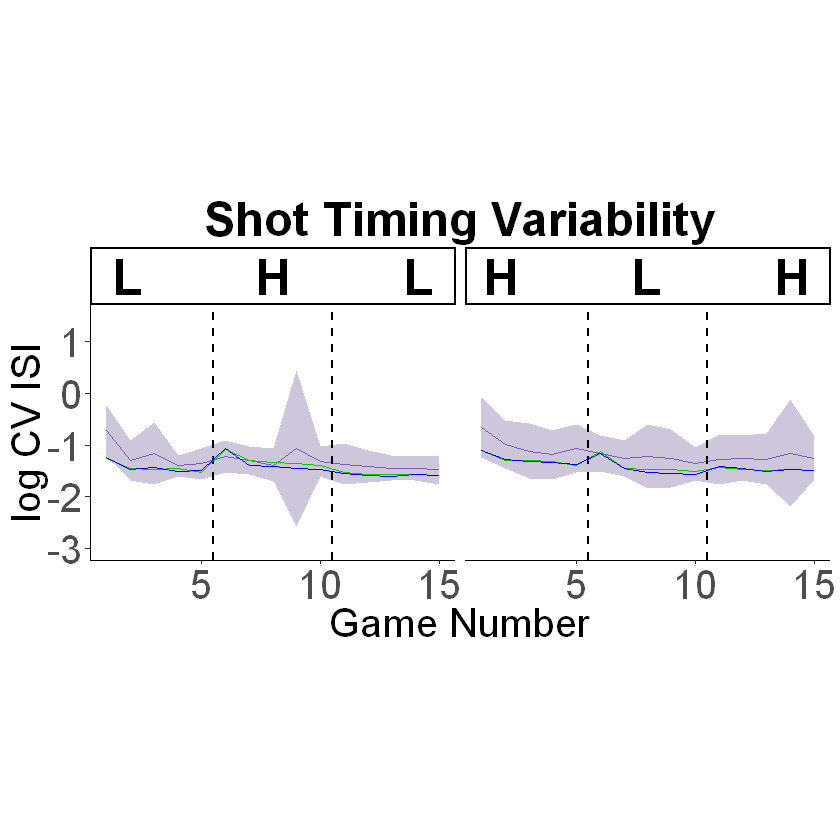

In [38]:
#logCV_ISI
Shaded <- data %>% filter(Temperature=='Human')
datac0 <- summarySE(Shaded, measurevar="lCV", groupvars=c("GameSpeed","GameNb","Agent"))
Tra1 <- data %>% filter(Temperature=='no')
datac_c1 <- summarySE(Tra1, measurevar="lCV", groupvars=c("GameSpeed","GameNb"))
Tra2 <- data %>% filter(Temperature=='yes')
datac_c2 <- summarySE(Tra2, measurevar="lCV", groupvars=c("GameSpeed","GameNb"))
rmseLCV <- format(round(All_rmses$logCV, 2), nsmall = 2)
rmseLCV2 <- format(round(All_rmses_M2$logCV, 2), nsmall = 2)

p0 <- ggplot(datac0) +  geom_line(aes(x=GameNb, y=lCV,color=Agent)) + geom_ribbon(aes(x=GameNb, ymin=lCV-sd, ymax=lCV+sd, fill="Human SD")) +
     theme_classic() +
      ggtitle("Shot Timing Variability") +
      theme(plot.title = element_text(size=28,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 24),
           strip.text = element_text(size = 30,face ="bold",color='black'),
           axis.title = element_text( size = 24 ),
           legend.text = element_text( size = 28),
           legend.title = element_text( size = 28),
           legend.position = 'none',
           aspect.ratio=ar
          ) +
     geom_vline(xintercept=c(5.5,10.5),linetype="dashed",lwd=0.6) +
         guides(color = guide_legend(override.aes = list(size=1.5))) +
         scale_fill_manual(values = alpha(c("mediumpurple4"), .3), name = "Variation") + 
         scale_color_manual(values = c("mediumpurple3","blue","green3"), name = "Agent means") +
     scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
     scale_y_continuous(name="log CV ISI", limits=c(-3.0,1.5))
p0 <- p0+ geom_line(data = datac_c1, aes(x=GameNb, y=lCV,color="Model (2 Temp.)")) +
      geom_line(data = datac_c2, aes(x=GameNb, y=lCV,color="Model (1 Temp.)")) 
h5 <- p0+facet_wrap(~ GameSpeed, labeller = labeller(GameSpeed = NewLabs), nrow = 1)
h5
pathFig <- '../Figures/lCV_temperature.png'
ggsave(pathFig,h5,width=20,height=15)

In [39]:
toSave2 <- ggarrange(h2,h3,h5,h4, ncol=2, nrow=2, common.legend = TRUE, legend="right")
ggsave("../Figures/Fig6_II.tiff",toSave2,width=24,height=9,dpi=1200)

In [40]:
ggsave("../Figures/Fig6_FULL.tiff",multiplot(toSave,toSave2, cols=1),width=24,height=18,dpi=1000)